# XGBoost Version 4


In [39]:
# packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import time
import datetime
import random
from scipy import stats
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [40]:
# Import the data and prepare for further processing
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path, parse_dates=['date'])
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.set_index('date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [41]:
# Import the data
df = load_and_prepare_data('../../data/Final_data/final_data.csv')

# Reset the index
df = df.reset_index()


In [42]:
# Creating more features using the date column
df["day_of_week"] = df["date"].dt.dayofweek
df["day_of_year"] = df["date"].dt.dayofyear
df["month"] = df["date"].dt.month
df["quarter"] = df["date"].dt.quarter
df["year"] = df["date"].dt.year

df.head()

,date,Day_ahead_price,BEV_vehicles,Biomass (GWh),Hard Coal (GWh),Hydro (GWh),Lignite (GWh),Natural Gas (GWh),Nuclear (GWh),Oil_price (EUR),...,Temperature,Wind offshore (GWh),Wind onshore (GWh),Wind_speed,net_total_export_import (GWh),day_of_week,day_of_year,month,quarter,year
0,2012-01-01,18.1896,6,98.605,108.454,51.011,325.337,188.811,250.979,98.99,...,8.39,3.404,235.467,4.95,54.662,6,1,1,1,2012
1,2012-01-02,33.8188,6,98.605,222.656,51.862,343.168,229.293,258.671,99.39,...,7.41,3.350,231.772,5.00,-64.477,0,2,1,1,2012
2,2012-01-03,35.0263,6,98.605,162.204,48.851,336.773,241.297,271.495,99.79,...,5.23,7.292,504.484,7.77,-35.078,1,3,1,1,2012
3,2012-01-04,32.1633,6,98.605,189.633,47.101,323.976,252.289,270.613,102.48,...,4.78,7.828,541.528,8.04,22.924,2,4,1,1,2012
4,2012-01-05,20.3500,6,98.605,175.733,45.854,327.502,259.018,287.555,103.24,...,4.23,8.280,572.819,9.98,35.618,3,5,1,1,2012


### Train/Testspilt

In [43]:
def train_test_split_sequential(data, test_size=0.2):
    """
    Split the sequence data into training and testing datasets sequentially.
    
    Parameters:
    - data: List of tuples where each tuple contains (sequence, label).
    - test_size: Fraction of the dataset to be used as test data.

    Returns:
    - train_data: Training data containing sequences and labels.
    - test_data: Testing data containing sequences and labels.
    """
    split_idx = int(len(data) * (1 - test_size))  # Calculate split index
    train_data = data[:split_idx]
    test_data = data[split_idx:]
    return train_data, test_data

train_df, test_df= train_test_split_sequential(df, test_size=0.2)

In [44]:
df

,date,Day_ahead_price,BEV_vehicles,Biomass (GWh),Hard Coal (GWh),Hydro (GWh),Lignite (GWh),Natural Gas (GWh),Nuclear (GWh),Oil_price (EUR),...,Temperature,Wind offshore (GWh),Wind onshore (GWh),Wind_speed,net_total_export_import (GWh),day_of_week,day_of_year,month,quarter,year
0,2012-01-01,18.1896,6,98.605,108.454,51.011,325.337,188.811,250.979,98.99,...,8.39,3.404,235.467,4.95,54.662,6,1,1,1,2012
1,2012-01-02,33.8188,6,98.605,222.656,51.862,343.168,229.293,258.671,99.39,...,7.41,3.350,231.772,5.00,-64.477,0,2,1,1,2012
2,2012-01-03,35.0263,6,98.605,162.204,48.851,336.773,241.297,271.495,99.79,...,5.23,7.292,504.484,7.77,-35.078,1,3,1,1,2012
3,2012-01-04,32.1633,6,98.605,189.633,47.101,323.976,252.289,270.613,102.48,...,4.78,7.828,541.528,8.04,22.924,2,4,1,1,2012
4,2012-01-05,20.3500,6,98.605,175.733,45.854,327.502,259.018,287.555,103.24,...,4.23,8.280,572.819,9.98,35.618,3,5,1,1,2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4434,2024-02-25,61.0938,947,123.683,48.501,58.671,193.697,255.124,0.000,74.73,...,4.52,29.879,278.787,3.43,-36.930,6,56,2,1,2024
4435,2024-02-26,66.2683,947,124.810,69.146,58.444,281.177,289.764,0.000,74.60,...,4.96,62.336,239.555,3.12,-198.686,0,57,2,1,2024
4436,2024-02-27,73.8362,947,124.989,103.379,59.181,351.355,354.042,0.000,75.61,...,4.53,16.951,131.761,3.11,-209.332,1,58,2,1,2024
4437,2024-02-28,71.8213,947,125.068,93.416,58.160,350.348,338.216,0.000,76.07,...,3.69,68.585,76.355,2.46,-206.956,2,59,2,1,2024


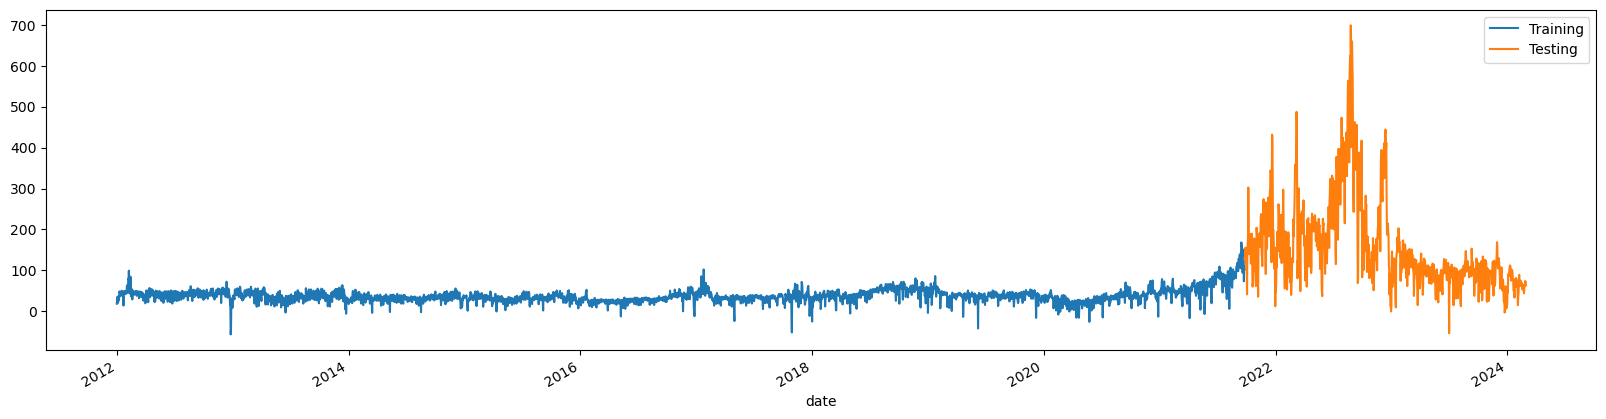

In [45]:
figure, ax = plt.subplots(figsize=(20, 5))
train_df.plot(ax=ax, label="Training", x="date", y="Day_ahead_price")
test_df.plot(ax=ax, label="Testing", x="date", y="Day_ahead_price")
plt.show()

In [46]:
# Dropping unnecessary `date` column
training_data = train_df.drop(columns=["date"])
testing_dates = test_df["date"]
testing_data = test_df.drop(columns=["date"])

X_train = training_data.iloc[:, 1:] # Features
y_train = training_data["Day_ahead_price"] # Target

X_test = testing_data.iloc[:, 1:] # Features
y_test = testing_data["Day_ahead_price"] # Target

In [47]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer


# Define the model
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    gamma=0.1,             # Minimum loss reduction required to make a further partition
    reg_lambda=1,          # L2 regularization term on weights (like Ridge regression)
    reg_alpha=0.1          # L1 regularization term on weights (like Lasso regression)
)



# Define the hyperparameter space
search_spaces = {
    'learning_rate': Real(0.01, 0.5, 'log-uniform'),
    'max_depth': Integer(3, 10),
    'min_child_weight': Integer(1, 10),
    'subsample': Real(0.5, 1.0, 'uniform'),
    'colsample_bytree': Real(0.5, 1.0, 'uniform'),
    'n_estimators': Integer(100, 1000),
}

# Setup Bayesian optimization
bayes_cv_tuner = BayesSearchCV(
    estimator = xgb_model,
    search_spaces = search_spaces,
    scoring = 'neg_mean_squared_error',
    cv = 3,
    n_iter = 32,
    n_jobs = -1,
    return_train_score = True,
    refit = True,
    random_state = 42
)

# Perform the Bayesian optimization
bayes_cv_tuner.fit(X_train, y_train)

# Best parameters found
print("Best parameters found: ", bayes_cv_tuner.best_params_)

# Best model
best_model = bayes_cv_tuner.best_estimator_

from sklearn.metrics import mean_squared_error

# Predict on the test set
prediction = best_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, prediction))
print(f"Test RMSE: {rmse}")

/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5, 0.49999999999999994, 10, 10, 100, 1.0] before, using random point [0.7355744223971193, 0.20417997903457516, 8, 4, 657, 0.7103456899029118]
  warnings.warn(
/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [0.5, 0.49999999999999994, 10, 10, 100, 1.0] before, using random point [0.524998847065822, 0.26241536076480554, 7, 10, 360, 0.8516049455073496]
  warnings.warn(


Best parameters found:  OrderedDict([('colsample_bytree', 0.608138582372449), ('learning_rate', 0.49999999999999994), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 100), ('subsample', 1.0)])
Test RMSE: 127.91826497558068


/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 1 RMSE: 4.206384131955993


/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 2 RMSE: 4.473896498409532


/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 3 RMSE: 4.779949184872273


/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 4 RMSE: 5.607774918087564


/Users/skyfano/Documents/Masterarbeit/Prediction_of_energy_prices/master_thesis/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


Fold 5 RMSE: 4.402507138625083
Average RMSE across folds: 4.69410237439009
RMSE on the entire dataset: 125.91393610386106


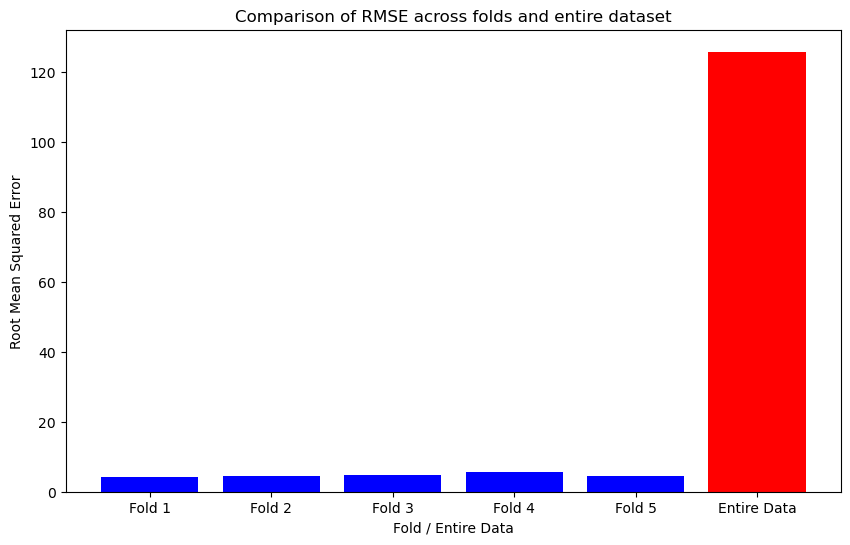

In [55]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Assuming X_train and y_train are already defined and preprocessed
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmses = []  # List to store the RMSE of each fold
fold_index = 1

for train_index, test_index in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model = XGBRegressor(objective='reg:squarederror', n_estimators=500, max_depth=5)
    model.fit(X_train_fold, y_train_fold, early_stopping_rounds=50, eval_set=[(X_test_fold, y_test_fold)], verbose=False)
    
    predictions = model.predict(X_test_fold)
    mse = mean_squared_error(y_test_fold, predictions)
    rmse = np.sqrt(mse)
    rmses.append(rmse)
    print(f"Fold {fold_index} RMSE: {rmse}")
    fold_index += 1

average_rmse_cv = np.mean(rmses)
print("Average RMSE across folds:", average_rmse_cv)

# Train on the entire dataset and compute RMSE
model.fit(X_train, y_train)
predictions_entire = model.predict(X_test)
mse_entire = mean_squared_error(y_test, predictions_entire)
rmse_entire = np.sqrt(mse_entire)
print("RMSE on the entire dataset:", rmse_entire)

# Plotting both RMSEs for comparison
plt.figure(figsize=(10, 6))
plt.bar(range(1, 7), rmses + [rmse_entire], color=['blue']*5 + ['red'])
plt.xlabel('Fold / Entire Data')
plt.ylabel('Root Mean Squared Error')
plt.title('Comparison of RMSE across folds and entire dataset')
plt.xticks(range(1, 7), labels=[f"Fold {i}" for i in range(1, 6)] + ['Entire Data'])
plt.show()


In [48]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error,\
  mean_squared_error

def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
  # Calculate RMSE
  rmse = np.sqrt(mean_squared_error(y_test, prediction))
  print(f"RMSE: {rmse}")

def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"date": testing_dates, "actual": y_test, "prediction": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Actual", x="date", y="actual")
  df_test.plot(ax=ax, label="Prediction", x="date", y="prediction")
  plt.legend(["Actual", "Prediction"])
  plt.show()

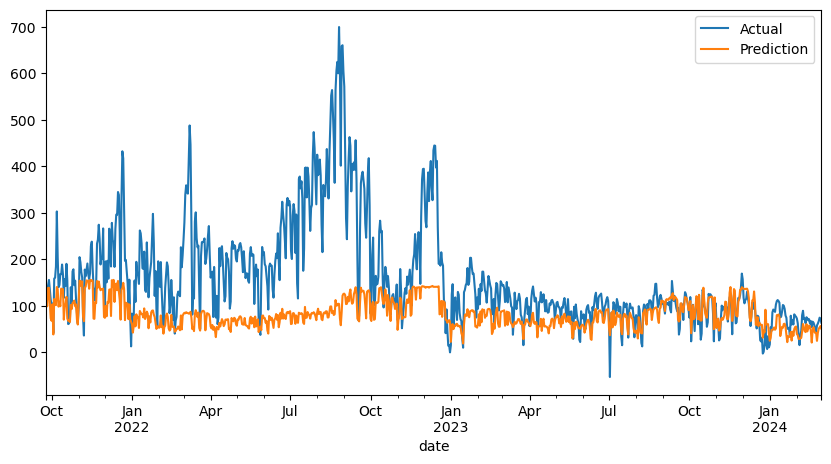

MAE: 83.13538391947704
MSE: 16363.082514362872
MAPE: 0.680677529975266
RMSE: 127.91826497558068


In [52]:
prediction = best_model.predict(X_test)
plot_predictions(testing_dates, y_test, prediction)
evaluate_model(y_test, prediction)